In [92]:
%matplotlib inline
import forestci as fci
from matplotlib import pyplot as plt
import pandas as pd
import os
import numpy as np
import sklearn.cross_validation as xval
from scipy.stats import pearsonr
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from statsmodels.formula.api import ols

DATAPATH = '../data'
dataset = pd.read_csv(os.path.join(DATAPATH, "autosomal_perlocus_train_intergenic.bed.gz"), sep="\t").drop_duplicates()
dataset['period'] = dataset['motif'].str.len()
features = ['uninterrupted_length', 'length','period','recomb','gc','entropy','reptiming']

# Filter to things with length >=25, period is di, tri, or tetra
dataset = dataset[(dataset["uninterrupted_length"]>=20)&(dataset["period"].apply(lambda x: x in [2,3,4]))]
dataset = dataset[~dataset["featurefilter"]]

In [93]:
dataset.head()

,chrom,start,end,ml_mu,ml_beta,ml_p,ml_mu_stderr,numsamples,strfilter,motif,length,uninterrupted_length,recomb,gc,entropy,reptiming,featurefilter,period
40,1,6464771,6464818,-3.008689,2.006161e-07,0.999902,0.166666,298,PASS,AAAT,48,48,0.001615,0.59,1.968911,1.578923,False,4
76,1,6830345,6830364,-7.674326,2.505950e-01,0.999709,0.000000,211,PASS,AAT,20,20,0.030975,0.56,1.982315,0.960401,False,3
102,1,8055676,8055714,-3.701994,2.066699e-06,0.919629,0.204250,293,PASS,AAAT,39,34,1.300130,0.41,1.964974,0.757793,False,4
124,1,8065674,8065709,-7.674331,1.155046e-01,0.954582,0.000000,86,PASS,AAGG,36,23,0.787018,0.47,1.967579,0.756587,False,4
134,1,8089800,8089825,-4.164805,6.553952e-05,0.843995,0.259567,301,PASS,AC,26,26,0.000000,0.33,1.909423,0.760734,False,2


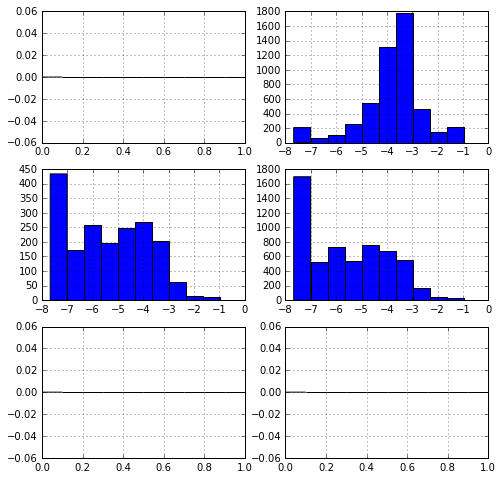

In [94]:
fig, ((axis1, axis2), (axis3, axis4), (axis5, axis6)) = plt.subplots(3,2, figsize=(8, 8))
for i in range(1, 7):
    axes = [axis1, axis2, axis3, axis4, axis5, axis6]
    dataset[dataset['period']==i]['ml_mu'].hist(ax=axes[i-1])

The above figure indicates that the data is unbalanced, especially for those data whose motif length is greater than 1, the amount of data with **ml_mu < -7** is too large. And since **ml_mu < -7** usually indicates the estimation is not accurate, so those data will greatly affect our prediction, thus should be dropped or resampled.

**edit from MGymrek**
Restricting to things with length >=25 gives a much nicer distribution. This is not ideal but perhaps models on those can extend to the shorter, less mutable loci if the trends are all  linear.

Try drop firtst, then try resample.

In [95]:
dataset = dataset[dataset['ml_mu'] > -7.5][dataset['ml_mu'] < -1] # Remove things at the optimization boundaries for mu
dataset = dataset[dataset['ml_beta'] < 0.899][dataset["ml_beta"] > 0.001] # Remove things at the optimization boundaries for beta

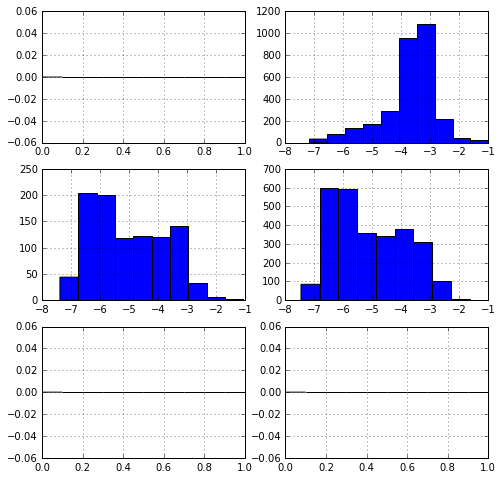

In [96]:
fig2, ((axis1, axis2), (axis3, axis4), (axis5, axis6)) = plt.subplots(3,2, figsize=(8, 8))
for i in range(1, 7):
    axes = [axis1, axis2, axis3, axis4, axis5, axis6]
    dataset[dataset['period']==i]['ml_mu'].hist(ax=axes[i-1])

In [97]:
traintest_num = 15000
basic_X = dataset[features][:traintest_num]
basic_y = dataset['ml_mu'][:traintest_num]
train_X, test_X, train_y, test_y = xval.train_test_split(basic_X, basic_y, test_size=0.25)

# Linear Regression

0.584639176631
(0.76491285866400049, 0.0)


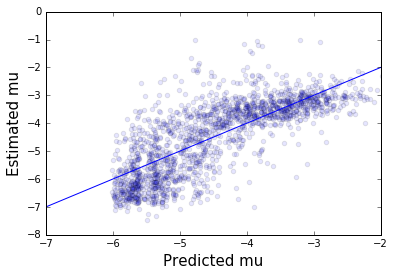

In [98]:
lr = LinearRegression()
lr.fit(train_X, train_y)
print lr.score(test_X, test_y)
plt.scatter(lr.predict(test_X), test_y, alpha=0.1)
plt.plot([-7, -2],[-7,-2])
plt.xlim(left=-7, right=-2)
plt.xlabel("Predicted mu", size=15)
plt.ylabel("Estimated mu", size=15)
print pearsonr(test_y, lr.predict(test_X))

# Random Forest

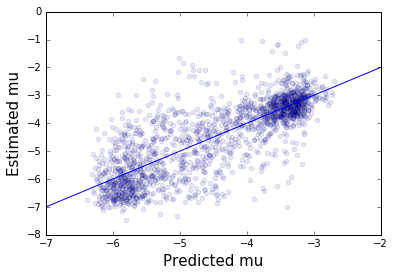

0.614781659296
(0.78421132149540151, 0.0)


In [99]:
rf = RandomForestRegressor(max_depth=50, min_samples_leaf=10, n_estimators=10)
# weights = np.array([0.1 if mu < -5 else 1 for mu in train_X['period']])
rf.fit(train_X, train_y)
pred_y = rf.predict(test_X)
plt.scatter(pred_y, test_y, alpha=0.1)
plt.plot([-7, -2],[-7,-2])
plt.xlim(left=-7, right=-2)
plt.xlabel("Predicted mu", size=15)
plt.ylabel("Estimated mu", size=15)
plt.show()
print rf.score(test_X, test_y)
print pearsonr(test_y, pred_y)

In [100]:
inbag = fci.calc_inbag(train_X[:20000].shape[0], rf)
unbiased = fci.random_forest_error(rf, inbag, train_X[:20000], test_X[:20000])

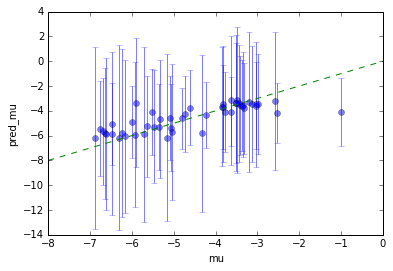

In [101]:
plot_size = 50

plt.errorbar(test_y[:plot_size], pred_y[:plot_size], yerr=np.sqrt(unbiased[:plot_size]), fmt='o', alpha=0.5)
plt.plot([-8, 0], [-8, 0], '--')
plt.xlabel('mu')
plt.ylabel('pred_mu')
plt.show()

In [102]:
rf.feature_importances_

array([ 0.64257501,  0.02631718,  0.20545744,  0.02944839,  0.02420901,
        0.03735871,  0.03463426])

# Compare models

[]

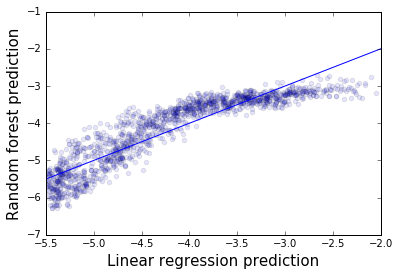

In [103]:
plt.scatter(lr.predict(test_X), rf.predict(test_X), alpha=0.1)
plt.xlabel("Linear regression prediction", size=15)
plt.ylabel("Random forest prediction", size=15)
plt.plot([-5.5, -2],[-5.5,-2])
plt.xlim(left=-5.5, right=-2)
plt.plot()

# Make predictions

In [104]:
dataset = pd.read_csv(os.path.join(DATAPATH, "autosomal_perlocus_observed.bed.gz"), sep="\t").drop_duplicates()
dataset['period'] = dataset['motif'].str.len()
dataset['pred_mu'] = rf.predict(dataset[features])
header = ['chrom','start','end','ml_mu','ml_beta','ml_p','ml_mu_stderr','numsamples','strfilter','motif',
          'length','uninterrupted_length','recomb','gc,entropy','reptiming','featurefilter','period','pred_mu','pred_mu_se']

In [105]:
# calculate inbag and unbiased variance
#all_X = dataset[features]
#inbag = fci.calc_inbag(train_X.shape[0], rf)
#unbiased = fci.random_forest_error(rf, inbag, train_X, all_X)
#dataset['pred_mu_se'] = np.sqrt(unbiased)

In [106]:
dataset.to_csv(os.path.join(DATAPATH, 'alex_rough_mu_prediction.csv'), columns=header, index=False)
dataset.head()

,chrom,start,end,ml_mu,ml_beta,ml_p,ml_mu_stderr,numsamples,strfilter,motif,length,uninterrupted_length,recomb,gc,entropy,reptiming,featurefilter,period,pred_mu
0,1,6075743,6075768,-7.674328,0.398885,0.899090,0.000000,296,PASS,AACC,26,18,0.746595,0.42,1.862236,1.257372,False,4,-5.827174
1,1,6077467,6077499,-3.620364,0.410529,0.811976,0.383819,298,PASS,AC,33,33,0.746595,0.50,1.973815,1.261710,False,2,-3.443650
2,1,6077849,6077863,-5.753837,0.465792,0.999998,1.275853,301,PASS,A,15,15,0.746595,0.58,1.962409,1.261710,False,1,-5.038850
3,1,6080725,6080742,-7.674329,0.763534,0.926531,0.000000,299,PASS,AAAT,18,14,0.746595,0.48,1.996624,1.269678,False,4,-5.965633
4,1,6081446,6081466,-7.674331,0.538737,0.954788,0.000000,296,PASS,AAAAAG,21,21,0.746595,0.39,1.964496,1.274279,False,6,-5.961028
